# Stainlib: Usage example of normalizing with a target image

## Download Openslide
Openslide appears to be very difficult to get running on Window, however, it works well in linux. Good luck, have fun...
Try downloading the zipped binaries yourself and extract them in a local folder.
Then add the path to the dll directory, and to the PATH environmental variable for good measure. This worked for me, sometimes.

Install Openslide windows-binaries and add OPENSLIDE_PATH
* `https://openslide.org/download/#windows-binaries`
* `OPENSLIDE_PATH = r'the\openslide\path\bin'`

## MRXS files
mrxs files are sometimes not suitable for Openslide. If this happens, conversion from mrxs-mrxs by 3DHISTECH's Slide Converter solves the problem.
Probably have potential fixes in future:
https://github.com/openslide/openslide/issues/251

To get .mrxs:
* get api-key from Jan
* use python library from Ajey and Jonas (https://github.com/NKI-AI/slidescore-api)
* `pth_origin = r'where\the\image\path'`

In [1]:
import os  # Hope for error-free passage here...
OPENSLIDE_PATH = r'D:\Python\Yuan\openslide-win64\bin'

if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [2]:
import sys
from pathlib import Path
pth = Path(Path.cwd().parent.parent)  # Add stainlib package in the path
sys.path.append(str(pth))
print(pth)
from Macenko import NormalizationCPU

D:\Python\Yuan\IHC_normalization


In [20]:
import numpy as np
import matplotlib
# matplotlib.use('QtAgg')
import matplotlib.pyplot as plt
import geojson
# import configparser
import pickle
import tifffile
from tifffile import TiffWriter
from tifffile import imread
from tqdm import tqdm
%matplotlib notebook
import time
import skimage

In [4]:
## Open mrxs files, geojson files path
slide_pth = Path( r'E:\1_DATA\BIF\yg_BIF\image\originalimages')
geojson_pth = Path( r'E:\1_DATA\BIF\yg_BIF\image\annotations')
slide_suffix = '.mrxs'
geojson_suffix = '.geojson'

## Find the correct annotation name
annotation_name = 'Tumor Tissue'

## Load target model, the model is pre-trained in another notebook
pth_model = Path(r'D:\Python\Yuan\IHC_normalization\Data\Models')
with open(Path(pth_model,"macenko1_CPUx.pickle"), "rb") as f:
    normalizer = pickle.load(f)
    
## Image output path
pth_out = Path( r'E:\1_DATA\BIF\yg_BIF\image\finaltest')

In [5]:
## Create slides dictory
def find_files(slide_pth, slide_suffix, geojson_pth, geojson_suffix):
    slide_list = []
    slide_dict = {}
    slide_generator = os.walk(slide_pth)
    geojson_generator = os.walk(geojson_pth)
    for slide_path, slide_dirs, slide_files in slide_generator:
        if len(slide_files) < 1:
            continue
        for slide_file in slide_files:
            slide_file_name, slide_suffix_name = os.path.splitext(slide_file)
            if slide_suffix_name == slide_suffix:
                slide_list.append(slide_file_name)
                slide_dict[slide_file_name]=[os.path.join(slide_path, slide_file)]
    for geojson_path, geojson_dirs, geojson_files in geojson_generator:
        if len(geojson_files) < 1:
            continue
        for geojson_file in geojson_files:
            geojson_file_name, geojson_suffix_name = os.path.splitext(geojson_file)
            if geojson_suffix_name == geojson_suffix:
                if geojson_file_name in slide_dict.keys():
                    slide_dict[geojson_file_name]+=[os.path.join(geojson_path, geojson_file)]
    return slide_list, slide_dict

all_slide = find_files(slide_pth, slide_suffix, geojson_pth, geojson_suffix)
slide_list = all_slide[0]
slide_dict = all_slide[1]

In [6]:
all_slides_info = {}

for i in range(len(slide_list)):
    for j in slide_dict[slide_list[i]]:
        if slide_suffix in j:
            slide_details = {}
            pth_origin = j
            slide_details['pth_origin'] = j
            slide_read = openslide.OpenSlide(j)
            slide_details['slide_read'] = slide_read
            slide_props = slide_read.properties 
            slide_details['X'] = float(slide_props['mirax.LAYER_0_LEVEL_0_SECTION.MICROMETER_PER_PIXEL_X'])
            slide_details['Y'] = float(slide_props['mirax.LAYER_0_LEVEL_0_SECTION.MICROMETER_PER_PIXEL_Y'])
            slide_details['x_offset'] = int(slide_props['mirax.NONHIERLAYER_0_LEVEL_0_SECTION.COMPRESSED_STITCHING_ORIG_SLIDE_SCANNED_AREA_IN_PIXELS__LEFT'])
            slide_details['y_offset'] = int(slide_props['mirax.NONHIERLAYER_0_LEVEL_0_SECTION.COMPRESSED_STITCHING_ORIG_SLIDE_SCANNED_AREA_IN_PIXELS__TOP'])
#             print(pth_origin)
#             print(X,Y)
#             print(x_offset, y_offset)
        elif geojson_suffix in j:
            pth_annotation = j
            slide_details['pth_annotation'] = pth_annotation
#             print(pth_annotation)
        slide_name = slide_list[i]
        all_slides_info[slide_name] = slide_details


In [7]:
## Find the position of annotation
def annotation_coord(pth_annotation, annotation_name, x_offset, y_offset):
    with open(pth_annotation) as f:
        tissue = geojson.load(f)
#         print(tissue)
        coordinates = file_stru(tissue, annotation_name)
#         print(coordinates)
        tissue_coordinates = coordinates[0]
#         print(tissue_coordinates)
        tissue_region = get_coord(tissue_coordinates)
#         print(tissue_region)
        tissue_position = position_cal(tissue_region, x_offset, y_offset)
        print(f'Tumor Tissue position (left, top, width, height): {tissue_position} \n')
    return tissue_position


## 3 functions
def file_stru(tissue, annotation_name):
    tissue_coords = []   
    if tissue['type'] == 'FeatureCollection':
        pass
    else:
        raise ValueError('The annotataion type is not the FeatureCollection!')
    features_length = len(tissue['features'])
    print(f'There are {features_length} annotation(s) in this geojson file.')
    for feature in tissue['features']:
        if 'classification' in feature['properties']:
            if 'name' in feature['properties']['classification']:
                classification_name = feature['properties']['classification']['name']
                if classification_name == annotation_name:
                    tissue_coord = feature['geometry']['coordinates']
                    for coord in tissue_coord:
                        tissue_coords.append(coord)
                else:
                    raise ValueError(f'The annotation name is wrong! Please check if it belongs to {annotation_name}.')
            else:
                raise ValueError('The annotation need a name!')
        else:
            raise ValueError('The annotations should have properties set. Please classified the annotation!')
    if not tissue_coords:
        raise ValueError(f'Warning! {annotation_name} annotation is empty.')
    return tissue_coords
        
def get_coord(coordinates):
    coordinates = [coordinates]
    list_depth = len(np.array(coordinates).shape)
#     print(list_depth)
    new_coordinates = []
    for num in coordinates:
        for i in range(list_depth-2):
            if i < (list_depth-3):
                num = num[0]
            else:
                for j in num:
                    new_coordinates.append(j)
#     print('New_coordinates is', new_coordinates)
    return new_coordinates

def position_cal(point_list, x_offset, y_offset):
    x = []
    y = []
    for i,j in point_list:
        x.append(i)
        y.append(j)
#     print(x)
    left = min(x) + x_offset - x_offset%256
    top = min(y) + y_offset - y_offset%256
    width = max(x) - min(x)
    height = max(y) - min(y)
    return left, top, width, height

In [8]:
all_slides_info['T16-02977 A1 Ki 67']

{'pth_origin': 'E:\\1_DATA\\BIF\\yg_BIF\\image\\originalimages\\16\\T16-02977 A1 Ki 67.mrxs',
 'slide_read': OpenSlide('E:\\1_DATA\\BIF\\yg_BIF\\image\\originalimages\\16\\T16-02977 A1 Ki 67.mrxs'),
 'X': 0.242534722222222,
 'Y': 0.242647058823529,
 'x_offset': 11037,
 'y_offset': 24876,
 'pth_annotation': 'E:\\1_DATA\\BIF\\yg_BIF\\image\\annotations\\T16-02977 A1 Ki 67.geojson'}

In [18]:
## Find Tumor Tissue position
slide = slide_list[2]
print(slide)
All_position = annotation_coord(all_slides_info[slide]['pth_annotation'], 
                                annotation_name,  
                                all_slides_info[slide]['x_offset'], 
                                all_slides_info[slide]['y_offset'])

annotation_position = All_position
tif_left = annotation_position[0]
tif_top = annotation_position[1]
tif_width = annotation_position[2]
tif_height = annotation_position[3]
print(tif_left, tif_top, tif_width, tif_height)
slide_origin = all_slides_info[slide]['slide_read']
X = all_slides_info[slide]['X']
Y = all_slides_info[slide]['Y']

T16-02977 A1 Ki 67
There are 1 annotation(s) in this geojson file.
Tumor Tissue position (left, top, width, height): (42921, 135009, 47406, 11261) 

42921 135009 47406 11261


In [10]:
all_slides_info[slide]['slide_read']

OpenSlide('E:\\1_DATA\\BIF\\yg_BIF\\image\\originalimages\\16\\T16-02977 A1 Ki 67.mrxs')

In [11]:
## Find Tumor Tissue region
time_start = time.time()

def rgba2rgb(rgba, background=(255,255,255)):
    row, col, ch = rgba.shape
    if ch == 3:
        return rgba
    assert ch == 4, 'RGBA image has 4 channels.'
    rgb = np.zeros( (row, col, 3))
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    a = np.asarray(a) / 255.0
    R, G, B = background
    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B
    return np.asarray(rgb, dtype='uint8')

slide_tif_whole = slide_origin.read_region((tif_left, tif_top), 0, (tif_width, tif_height))
slide_tif_rgba = np.asarray(slide_tif_whole)
slide_tif = rgba2rgb(slide_tif_rgba)

print(slide_tif.shape)

time_end = time.time()
print('time cost',time_end-time_start,'s')

(11261, 47406, 3)
time cost 73.0997166633606 s


<IPython.core.display.Javascript object>


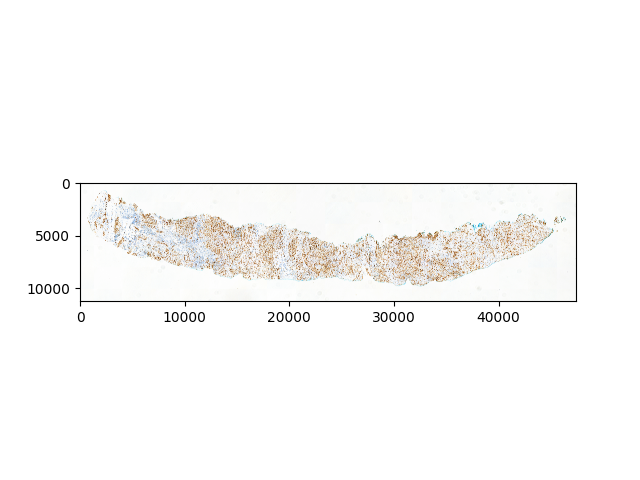

In [12]:
plt.imshow(slide_tif)
plt.show()

In [15]:
# slide_tif_whole = slide_origin.read_region((tif_left, tif_top), 0, (tif_width, tif_height))
# slide_tif_rgba = np.asarray(slide_tif_whole)
# slide_tif = skimage.color.rgba2rgb(slide_tif_rgba, background=(255,255,255))
# print(slide_tif.shape)

In [9]:
# ## Get source slide's stain vector and concentrations
# ## Standardize brightness (This step is optional but can improve the tissue mask calculation)
# slide_tile_transform = stainlib.utils.stain_utils.LuminosityStandardizer.standardize(slide_tile)
# slide_tile_matrix = stainlib.extraction.macenko_stain_extractor.MacenkoStainExtractor.get_stain_matrix(slide_tile_transform)
# slide_tile_concentrations = stainlib.utils.stain_utils.get_concentrations(slide_tile_transform, slide_tile_matrix)
# print(slide_tile_matrix)

[[0.61255646 0.77354654 0.1624818 ]
 [0.08075022 0.27214032 0.95886341]]


In [12]:
# ## Split slide to around 100 tiles
# size_x = int(slide_tif.shape[0]/1024)
# size_y = int(slide_tif.shape[1]/1024)
# if size_x > 0 and size_y > 0:
#     spitsizes = [int(slide_tif.shape[0]/1024),int(slide_tif.shape[1]/1024)]
# else:
#     spitsizes = [1,1]
# y = np.array_split(slide_tif, spitsizes[0], axis=0)
# tiles = []
# for x in y:
#     tiles.append(np.array_split(x, spitsizes[1], axis=1))

In [13]:
# ## Normalization
# time_start2 = time.time()

# transformed_tiles = []
# for tile_row in tqdm(tiles, position=0):
#     transformed_tile_row = []
#     for tile in tqdm(tile_row, position=1, leave=False):
#         transformed = normalizer.transform(tile)
#         to_transform_final = np.transpose(transformed, (2,0,1))
#         transformed_tile_row.append(to_transform_final)
#     transformed_tiles.append(transformed_tile_row)

# time_end2 = time.time()
# print('time cost',time_end2-time_start2,'s')

  0%|                                                                                                                                                                                                                              | 0/10 [00:45<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'reshape'

In [14]:
## Split slide to around 100 tiles
size_x = int(slide_tif.shape[0]/4000)
size_y = int(slide_tif.shape[1]/4000)
if size_x > 0 and size_y > 0:
    spitsizes = [int(slide_tif.shape[0]/4000),int(slide_tif.shape[1]/4000)]
else:
    spitsizes = [1,1]
y = np.array_split(slide_tif, spitsizes[0], axis=0)
tiles = []
for x in y:
    tiles.append(np.array_split(x, spitsizes[1], axis=1))

In [15]:
## Normalization
time_start2 = time.time()

transformed_tiles = []
for tile_row in tqdm(tiles, position=0):
    transformed_tile_row = []
    for tile in tqdm(tile_row, position=1, leave=False):
        transformed = normalizer.transform(tile)
        to_transform_final = np.transpose(transformed, (2,0,1))
        transformed_tile_row.append(to_transform_final)
    transformed_tiles.append(transformed_tile_row)

time_end2 = time.time()
print('time cost',time_end2-time_start2,'s')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [2:59:09<00:00, 5374.99s/it]

time cost 10749.98169374466 s


In [16]:
## Merge tiles to slide
rows=[]
for transformed_tile_row in transformed_tiles:
    rows.append(np.concatenate(transformed_tile_row, axis=2))
transformed_tile = np.concatenate(rows, axis=1)

In [22]:
## Save normalized slide
with TiffWriter(Path(pth_out,'a.ome.tif'), bigtiff=True) as tif:
    options = dict(photometric='rgb',tile=(1024, 1024), compression='jpeg',
                   metadata={'PhysicalSizeX': X, 'PhysicalSizeY': Y})
    tif.write(transformed_tile, subifds=4, **options)
    tif.write(transformed_tile[:, ::2, ::2], subfiletype=1, **options)
    tif.write(transformed_tile[:, ::4, ::4], subfiletype=1, **options)
    tif.write(transformed_tile[:, ::8, ::8], subfiletype=1, **options)
    tif.write(transformed_tile[:, ::16, ::16], subfiletype=1, **options)
print('Save Done')

Save Done
